In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
# from interaction_permutation_importance import *
import matplotlib.pyplot as plt

def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

sys.path.append('/root/barcode/')
from BarcodeScanner import tree_and_clustering, base_barcode
from importance_score import f_test_result
import scipy
from scipy.stats import f
from sklearn.base import BaseEstimator, clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics      import r2_score

import numpy as np; import pandas as pd
from typing import List, Union

# itertools
from itertools import combinations

from utils import *

class one_way_ANOVA(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, df, response_var_name =None):
        if response_var_name:
            try:
                df[response_var_name]
                self.response_var_name = response_var_name
            except:
                self.response_var_name = df.columns.tolist()[-1]
        else:
            self.response_var_name = df.columns.tolist()[-1]
        self.independet_var_name = df.columns[~df.columns.str.contains(self.response_var_name)].tolist()
        self.segment_means = df.groupby(self.independet_var_name)[self.response_var_name].mean().reset_index()
        self.segment_means.columns= self.segment_means.columns.tolist()[:-1] + ['y_hat']
        output = df.merge(self.segment_means, how = 'left', on = self.independet_var_name)
        y = output[self.response_var_name].to_numpy().reshape(-1)
        y_pred = output['y_hat'].to_numpy().reshape(-1)
        self._rsq = r2_score(y, y_pred)
        self.sse  = np.square(y - y_pred).sum()
        self.MSE_ = self.sse/(y.shape[0])
        output['sq'] = (output.y_hat - output[self.response_var_name])**2
        summary = output.groupby(self.independet_var_name).agg({"y_hat": np.mean, "sq": [lambda x: x.sum()/x.count(), 'count']}).reset_index()
        summary.columns = self.independet_var_name + ['group_means','mse','count']
        self._summary_table = summary
        return self
    

    @property
    def score(self):
        if hasattr(self, '_rsq'):
            return self._rsq
        else:
            raise AttributeError("fit the estimator first")
    
    @property
    def MSE(self):
        if hasattr(self, "MSE_"):
            return self.MSE_
        else:
            raise AttributeError("fit the estimator first")
class anova_clustering(base_barcode):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.clean_data()
        self.estimator = one_way_ANOVA()
        self.fit()

    def clean_data(self):
        full_df = self.X.copy()
        full_df['y'] = self.y.reshape(-1)
        sorted_index = full_df.sort_values(full_df.columns.tolist()[:-1]).index.tolist()
        self.full_df = full_df.loc[sorted_index, :].reset_index(drop = True)
        self.barcode_df = pd.DataFrame(zip(self.barcode.reshape(-1), self.y.reshape(-1)), columns = ['z','y']).loc[sorted_index, :].reset_index(drop = True)
        self.X = full_df.iloc[:, :-1]
        self.y = full_df.y.to_numpy().reshape(-1,1);
        self.num_full_var = 2**self.X.shape[1]
        self.num_main_var = self.X.shape[1]
        del sorted_index
        del full_df
        
    def fit(self):   
        self.estimator.fit(self.full_df)
        self._summary_table = self.estimator._summary_table
        self._fit = True

    def gen_clustering_summary_table(self, num_clusters):
        original_summary = self.summary_table.copy()
        original_summary = original_summary.drop(['group_means','mse', 'count'], axis = 1)
        original_summary['y_pred'] = self.get_projected_mu_hat(num_clusters)
        full_df = self.full_df.copy()
        full_df = full_df.merge(original_summary, on = self.estimator.independet_var_name, how = 'left')
        return full_df
    
    def metric_after_clustering(self, num_clusters, metric = r2_score):
        full_df = self.gen_clustering_summary_table(num_clusters)
        return metric(full_df.y, full_df.y_pred)



    @property
    def summary_table(self):
        if hasattr(self, "_summary_table"):
            pass
        else:
            self._summary_table = self.predict_from_training()
        return self._summary_table
    
    @property
    def init_mu_hat(self):
        if hasattr(self, "_init_mu_hat"):
            pass
        else:
            self._init_mu_hat = self.summary_table.group_means.tolist()
            self._init_mu_hat = np.array(self._init_mu_hat).reshape(-1)
        return self._init_mu_hat
    
    @property
    def init_mu_var(self):
        if hasattr(self, "_init_mu_var"):
            pass
        else:
            self._init_mu_var = np.diag(self.summary_table.mse/self.summary_table['count'])
        return self._init_mu_var
    
    @property
    def init_beta_hat(self):
        if hasattr(self, "_init_beta_hat"):
            pass
        else:
            self._init_beta_hat = self.L_inv @ self.init_mu_hat
        return self._init_beta_hat

    @property
    def init_beta_var(self):
        if hasattr(self, "_init_beta_var"):
            pass
        else:
            self._init_beta_var = self.L_inv @ self.init_mu_var @ self.L_inv.T
        return self._init_beta_var

    @property
    def clustering_init_kwargs(self):
        summary = self.summary_table
        kwargs = {"means": summary.group_means.tolist(), "variances": summary.mse.tolist(), "sample_sizes": summary['count'].tolist()}
        return kwargs
    
    @property
    def init_cluster_idx(self):
        if hasattr(self, "_init_cluster_idx"):
            pass
        else:
            sample_sizes = self.clustering_init_kwargs['sample_sizes']
            clusters = []
            last = 0
            for n in sample_sizes:
                clusters.append([x for x in range(last, n+last)])
                last += n
            self._init_cluster_idx = clusters
        return self._init_cluster_idx

    @property
    def init_pdist(self):
        if hasattr(self, "_init_pdist"):
            pass
        else:
            self._init_pdist = self.pairwise_distances_from_means_variances(**self.clustering_init_kwargs)
        return self._init_pdist

    def cluster(self, n_clusters, save = True):
        self.last_n_clusters = n_clusters
        pdist = self.init_pdist.copy()
        init_cluster_idx = self.init_cluster_idx.copy()
        result = self.agglomerative_clustering(pairwise_distances = pdist, n_clusters = n_clusters, clusters = init_cluster_idx)
        cluster_idx = result[0]
        final_pdist = result[1]
        cluster_df = {}
        for cluster_id, cluster_index in enumerate(cluster_idx):
            cluster_id_name = f"cluster_{cluster_id}"
            cluster_df[cluster_id_name] = self.full_df.loc[cluster_index,:].copy()
            cluster_df[cluster_id_name] = cluster_df[cluster_id_name].groupby(self.original_columns).agg(np.mean).reset_index()
            cluster_df[cluster_id_name]['barcode'] = self.gen_barcode((cluster_df[cluster_id_name].loc[:, self.original_columns]))
        if save:
            self._latest_cluster_dfs = cluster_df
        else:
            self._latest_cluster_dfs = None
        
        return {"cluster": cluster_df, "final_pdist": final_pdist}

    def gen_mu_contrast_from_cluster(self, n_clusters, use_latest_cluster_df = True):
        if use_latest_cluster_df:
            if hasattr(self, '_latest_cluster_dfs'):
                if (self._latest_cluster_dfs != None) & (self.last_n_clusters == n_clusters):
                    cluster_df_list = self._latest_cluster_dfs
        try:
            cluster_df_list
        except:
            cluster_result = self.cluster(n_clusters = n_clusters)
            cluster_df_list = cluster_result['cluster']
            
        contrast_matrix = 0
        for cluster_name, cluster_df in cluster_df_list.items():
            if cluster_df.shape[0] > 1:
                contrast = np.zeros((cluster_df.shape[0]-1, 2**len(self.original_columns)))
                for i, row in enumerate(contrast):
                    row[cluster_df.barcode[0]] = 1
                    row[cluster_df.barcode[i+1]] = -1
                    contrast[i] = row
                if isinstance(contrast_matrix, np.ndarray):
                    contrast_matrix = np.concatenate([contrast_matrix, contrast], axis = 0)
                else:
                    contrast_matrix = contrast
            else:
                pass
        return contrast_matrix
    
    def gen_projection_matrix_mu(self, n_clusters):
        C = self.gen_mu_contrast_from_cluster(n_clusters)
        projection_matrix = C.T @ np.linalg.inv(C @ C.T) @ C
        projection_matrix = np.identity(C.shape[1]) - projection_matrix
        return projection_matrix
    
    def get_projected_mu_hat(self, n_clusters):
        mu = self.init_mu_hat
        proj_mu = self.gen_projection_matrix_mu(n_clusters = n_clusters) @ mu
        return proj_mu
    
    def get_projected_mu_hat_var(self, n_clusters):
        mu_var = self.init_mu_var
        proj = self.gen_projection_matrix_mu(n_clusters = n_clusters)
        proj_mu_var = proj @ mu_var @ proj.T
        return proj_mu_var
    
    def get_projected_beta_hat(self, n_clusters):
        proj_mu = self.get_projected_mu_hat(n_clusters = n_clusters)
        proj_beta = self.L_inv @ proj_mu
        return proj_beta
    
    def get_projected_beta_hat_var(self, n_clusters):
        mu_var = self.get_projected_mu_hat_var(n_clusters)
        return self.L_inv @ mu_var @ self.L_inv.T

    
    def ward_linkage(self, pairwise_distances, clusters, merge_indices):
        clusters = clusters.copy()
        i, j = merge_indices
        cluster_i = clusters[i]
        cluster_j = clusters[j]
        n_i = len(cluster_i)
        n_j = len(cluster_j)
        n = pairwise_distances.shape[1]
        new_distances = pairwise_distances.copy()
        new_distances = np.delete(new_distances, merge_indices, axis = 0)
        new_distances = np.delete(new_distances, merge_indices, axis = 1)
        new_distances = np.append(new_distances, np.zeros((1, new_distances.shape[1])), axis = 0)
        new_distances = np.append(new_distances,  np.zeros((new_distances.shape[0], 1)), axis = 1)
        clusters.append(cluster_i + cluster_j)
        clusters.remove(cluster_i)
        clusters.remove(cluster_j)
        col = 0
        
        for k in range(n):  # Subtract 2 because we've already added a row and column
            if k != i and k != j:
                n_k = len(clusters[col])
                n_all = n_i + n_j + n_k
                dist_ik = pairwise_distances[i, k]*(n_k + n_i)/n_all
                dist_jk = pairwise_distances[j, k]*(n_j + n_k)/n_all
                dist_ij = pairwise_distances[i, j]*(n_k)/n_all
                new_dist = dist_ik + dist_jk - dist_ij
                # Add other linkage methods here if needed
                
                new_distances[-1, col] = new_dist
                new_distances[col, -1] = new_dist
                col += 1

        return new_distances, clusters
    
    def gen_reduced_clustering(self, n_clusters):
        return self.agglomerative_clustering(pairwise_distances= self.init_pdist, n_clusters = n_clusters)

    def agglomerative_clustering(self, pairwise_distances, n_clusters, clusters = None, estimator = None):
        n = pairwise_distances.shape[0]
        if clusters:
            pass
        else:
            clusters = [[i] for i in range(n)]
        
        assert len(clusters) == n
        
        for k in range(n - n_clusters):
            min_dist = np.inf
            merge_indices = None
            
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = pairwise_distances[i, j]
                    if dist < min_dist:
                        min_dist = dist
                        merge_indices = (i, j)
            
            if merge_indices:
                pairwise_distances, clusters = self.ward_linkage(pairwise_distances, clusters, merge_indices)
        
        return clusters, pairwise_distances
    
    def pairwise_distances_from_means_variances(self, means, variances, sample_sizes):
        num_clusters = len(means)
        pairwise_distances = np.zeros((num_clusters, num_clusters))
        
        for i in range(num_clusters):
            for j in range(i + 1, num_clusters):
                n_i = sample_sizes[i]
                n_j = sample_sizes[j]
                mean_i = means[i]
                mean_j = means[j]
                var_i = variances[i]
                var_j = variances[j]
                
                # Calculate the pairwise distance using Ward linkage formula
                numerator = (n_i * n_j / (n_i + n_j)) * (mean_i - mean_j)**2
                denominator = np.sqrt((n_i * var_i + n_j * var_j) / (n_i + n_j))
                
                pairwise_distances[i, j] = np.sqrt(numerator / denominator)
                pairwise_distances[j, i] = pairwise_distances[i, j]
        
        return pairwise_distances

    def contrast_generator(self, max_variables = None):
        from itertools import product
        from scipy.sparse import vstack
        all_interaction_betas = scipy.sparse.eye(self.num_full_var - self.num_main_var -1, self.num_full_var, k = self.num_main_var + 1)
        betas_in_test = product([False, True], repeat = self.num_full_var - self.num_main_var -1)
        
        def get_new_contrasts(beta):
            vstacks = []
            for i, b in enumerate(beta):
                if b:
                    vstacks.append(all_interaction_betas.getrow(i))
            return vstack(vstacks).astype(np.uint8)
        if max_variables is not None:
            for beta in betas_in_test:
                if sum(beta) and (sum(beta) <= max_variables):
                    yield get_new_contrasts(beta)
        else:
            for beta in betas_in_test:
                if sum(beta):
                    yield get_new_contrasts(beta)


    @staticmethod    
    def partial_f_test(contrast, L_inv, cell_means, cell_means_covariance, sample_size):
        assert contrast.shape[0] < contrast.shape[1]
        assert contrast.shape[1] == L_inv.shape[0]
        assert L_inv.shape[0] == L_inv.shape[1]
        assert cell_means_covariance.shape == L_inv.shape
        from numpy.linalg import inv
        nu_1 = contrast.shape[0]
        nu_2 = sample_size - L_inv.shape[0]
        contrast = contrast.toarray()

        LC = contrast @ L_inv.T
        mu = LC @ cell_means
        var = LC @ cell_means_covariance @ LC.T
        try:
            f_value = mu.T @ inv(var) @ mu
            f_value /= nu_1
        except:
            f_value = 0
        
        return f_test_result(nu_1, nu_2, f_value)
    
    def gen_importance_score(self, num_clusters, filename = 'importance_score.csv', dir = os.getcwd(), max_variables = None):
        cell_means = self.get_projected_mu_hat(num_clusters)
        covariance = self.get_projected_mu_hat_var(num_clusters)
        kwargs = {"L_inv": self.L_inv, "cell_means": cell_means, "cell_means_covariance": covariance, "sample_size": self.X.shape[0]}

        from csv import writer
        from tqdm import tqdm
        with open(os.path.join(dir, filename), 'w') as f:
            csv_writer = writer(f)
            csv_writer.writerow(self.beta_names + ['score'])
            contrasts =  self.contrast_generator(max_variables = max_variables)
            from math import comb
            if max_variables:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1, max_variables +1)])
            else:
                total_iter = sum([comb(self.num_full_var - self.num_main_var -1, x) for x in range(1,self.num_full_var - self.num_main_var)])
            for contrast in tqdm(contrasts, total = total_iter):
                result = self.partial_f_test(contrast = contrast, **kwargs)
                score = result.cdf
                row = contrast.sum(axis = 0).tolist()[0] + [score]
                csv_writer.writerow(row)
            else:
                from joblib import Parallel, delayed
                num_cores = os.cpu_count()
                batch_size = 1000 * num_cores
                partition_size = 1000
                contrast_batch = []
                for i, contrast in tqdm(enumerate(contrasts), total = total_iter):
                    contrast_batch.append(contrast)
                    if len(contrast_batch) % batch_size == 0:
                        f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                        f_test_results = [x.cdf for x in f_test_results]
                        rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                        csv_writer.writerows(rows)
                        del contrast_batch
                        del rows
                        del f_test_results
                        contrast_batch = []
                # process the remainder
                if len(contrast_batch):
                    f_test_results = Parallel(n_jobs=num_cores)(delayed(self.partial_f_test)(c, **kwargs) for c in contrast_batch)
                    f_test_results = [x.cdf for x in f_test_results]
                    rows = [c.sum(axis = 0).tolist()[0] + [f] for c,f in zip(contrast_batch, f_test_results)]
                    csv_writer.writerows(rows)

from glob import glob
import pandas as pd
from dask import dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import joblib
@dataclass
class f_test_result:
    nu_1:int
    nu_2:int
    f_statistic: float
    
    @property
    def p_value(self):
        if hasattr(self, '_p_value'):
            pass
        else:
            sdf = f.sf(self.f_statistic, self.nu_1, self.nu_2, loc=0, scale=1)
            self._p_value = sdf
        return self._p_value
    
    @property
    def cdf(self):
        if hasattr(self, '_cdf'):
            pass
        else:
            self._cdf = 1 - self.p_value
        return self._cdf
from math import sqrt


In [2]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append('/root/barcode/')
sys.path.append('../')
from BarcodeScanner import tree_and_clustering, base_barcode
from itertools import product, combinations
from sklearn.linear_model import LinearRegression
import timeit
from datasets import Dataset

def gen_X(num_var: int, sample_size : int):
    data_dictionary = {}
    for i in range(num_var):
        var_name = "x" + f"{i + 1}"
        data_dictionary[var_name] = list(np.random.binomial(1, .5, sample_size))
    return pd.DataFrame(data_dictionary)

def gen_full_X(X):
    raw_X = X.copy()
    colnames = raw_X.columns
    for k in range(2, len(colnames)+ 1):
        interaction_generator = combinations(colnames, k)
        for interaction_tuple in interaction_generator:
            new_colname = "*".join(interaction_tuple)
            raw_X[new_colname] = raw_X[list(interaction_tuple)].apply(np.prod, axis = 1)
    return raw_X


def gen_barcode_dataloader(num_var:int, sample_size:int):
    raw_X = gen_X(num_var = num_var, sample_size = sample_size)
    colnames = [
        f"x{i+1}" for i in range(num_var)
    ]
    from datasets import Dataset

    dataset = Dataset.from_pandas(raw_X)
    def gen_z(examples):
        example_list = [examples[x] for x in colnames]
        df = pd.DataFrame(zip(*example_list), columns= colnames)
        barcodes = base_barcode.gen_barcode(df).reshape(-1).tolist()
        y = df.apply(lambda seq: 1 + seq.x1 + seq.x2 + seq.x1*seq.x3 + np.random.normal(), axis = 1).tolist()
        return {"z": barcodes, "y":y}
    dataset = dataset.map(gen_z, batched = True, remove_columns=colnames)
    return dataset

/root/barcode/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sample_data = gen_X(5, 1000)

In [4]:
sample_full_data = gen_full_X(sample_data)

In [5]:
y = np.random.normal(size = 1000)

In [7]:
barcode = anova_clustering(sample_data, y.reshape(-1,1))

In [ ]:
import torch
from torch import nn

class Lasso_Barcode(nn.Module):
    def __init__(self, L):
        super().__init__()
        barcode_size = L.shape[0]
        L = torch.from_numpy(L.astype(float))
        self.embedding = nn.Embedding(barcode_size, barcode_size)
        self.embedding.weight = nn.Parameter(L.to(torch.float32), requires_grad = False)
        self.linear = nn.Linear(barcode_size, 1, bias = False, dtype = torch.float32)

    def init_linear_weight(self, X_sample, y_sample):
        barcode = anova_clustering(sample_data, y.reshape(-1,1))
        init_beta_hat = torch.from_numpy(barcode.init_beta_hat).to(torch.float32)
        self.linear.weight.data = init_beta_hat
        return init_beta_hat

    def l1_reg(self):
        return torch.abs(self.linear.weight).sum()

    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        return x, self.l1_reg()

: 

#### When $p*$ is 6

hiarchical : $y = 1 + x_1 + x_2 + x_3 + x_1 x_2 + x_1 x_3$

In [3]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x1 * seq.x2 + seq.x1 * seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [4]:
from scipy.spatial.distance import euclidean

In [5]:
sample_size = 1000
X = gen_X(5, sample_size)
X_full = gen_full_X(X)
y = X.apply(gen_y, axis = 1)
y.name = 'y'
df = pd.concat([X, y], axis = 1)
clustering = anova_clustering(df.iloc[:, :-1], df.y)

true_beta = ['beta0','beta1','beta2','beta3','beta1*beta2', 'beta1*beta3']
true_beta_coef = np.array([True if x in true_beta else False for x in clustering.beta_names])

num_clusters = list(range(2, 2**5))
tau_estimates = []
true_distance = []
false_distance = []
for k in num_clusters:
    tau_est = tau(df.shape[0], 2**5, k, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = k))
    tau_estimates.append(tau_est.tau_est)
    true_pred = clustering.get_projected_beta_hat(k)[true_beta_coef]
    false_pred = clustering.get_projected_beta_hat(k)[~true_beta_coef]

    true_distance.append(euclidean([1 for _ in range(6)], true_pred))
    false_distance.append(euclidean([0 for _ in range(26)], false_pred))
    
tau_output = pd.DataFrame(zip(num_clusters, tau_estimates, true_distance, false_distance), columns = ['num_clusters','tau_estimates', 'true_distance','false_distance'])




In [6]:
from sklearn.linear_model import Lasso, LinearRegression
d_f = 32
alpha = 0
reg = LinearRegression()
reg.fit(X_full, y)
org_score = reg.score(X_full, y)
degrees_of_freedom = []
tau_estimates = []
alphas = []
true_distance = []
false_distance = []

while d_f > 2:
    alpha += 0.001
    lasso = Lasso(alpha = alpha, fit_intercept = True)
    lasso.fit(X_full, y)
    lasso_coef = np.array([lasso.intercept_] + lasso.coef_.tolist())
    d_f = np.where(lasso_coef > 0.00001, 1, 0).sum()
    tau_est = tau(X_full.shape[0], 2**5, d_f, org_score, lasso.score(X_full, y))
    if (d_f not in degrees_of_freedom) & (d_f < 32):
        degrees_of_freedom.append(d_f)
        tau_estimates.append(tau_est)
        alphas.append(round(alpha, 3))
        false_pred = lasso_coef[~true_beta_coef]
        true_pred = lasso_coef[true_beta_coef]
        false_distance.append(euclidean([0 for _ in range(26)], false_pred))
        true_distance.append(euclidean([1 for _ in range(6)], true_pred))
tau_output_lasso = pd.DataFrame(zip(degrees_of_freedom, [x.tau_est for x in tau_estimates], true_distance, false_distance), columns = ['num_clusters','tau_estimates', 'true_distance','false_distance'])

In [7]:
tau_output_lasso = pd.DataFrame(zip(degrees_of_freedom, [x.tau_est for x in tau_estimates], true_distance, false_distance), columns = ['num_clusters','tau_estimates', 'true_distance','false_distance'])

In [8]:
tau_output_lasso['model'] = 'lasso'
tau_output['model'] = 'cluster'

In [9]:
tau_output = pd.concat([tau_output_lasso, tau_output])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

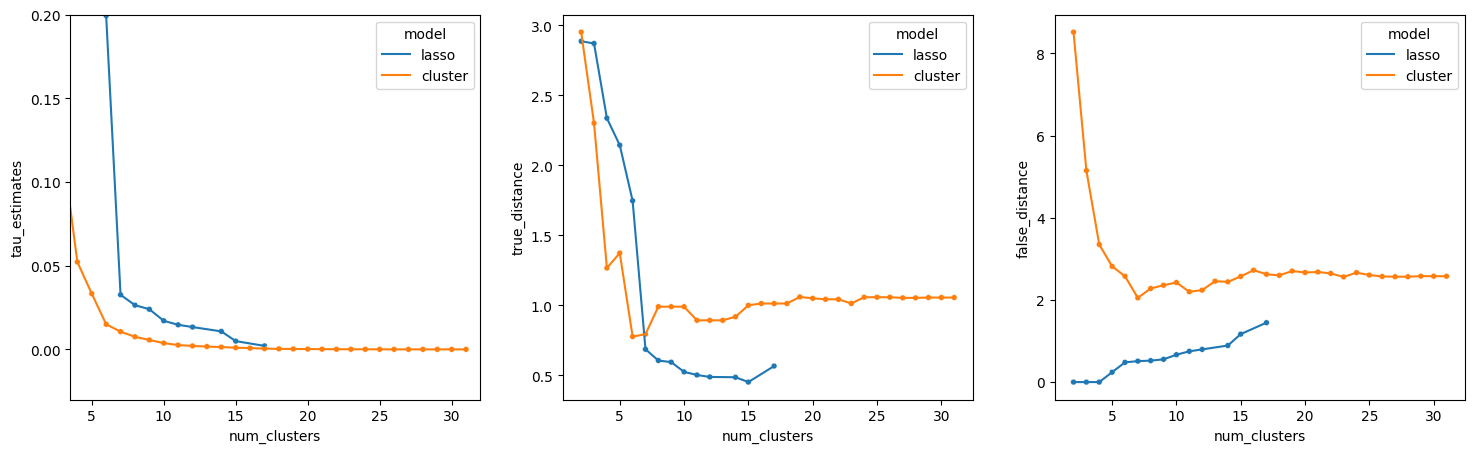

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (18, 5))
sns.scatterplot(tau_output, x = 'num_clusters', y = 'tau_estimates', hue = 'model', ax = ax[0], size = 0.5, legend= False)
sns.lineplot(tau_output, x = 'num_clusters', y = 'tau_estimates', hue = 'model', ax = ax[0])
ax[0].set_xlim(3.5, 32)
ax[0].set_ylim(-0.03, 0.2)

sns.scatterplot(tau_output, x = 'num_clusters', y = 'true_distance', hue = 'model', ax = ax[1], size = 0.5, legend= False)
sns.lineplot(tau_output, x = 'num_clusters', y = 'true_distance', hue = 'model', ax = ax[1])

sns.scatterplot(tau_output, x = 'num_clusters', y = 'false_distance', hue = 'model', ax = ax[2], size = 0.5, legend= False)
sns.lineplot(tau_output, x = 'num_clusters', y = 'false_distance', hue = 'model', ax = ax[2])

plt.show()

#### Simulations of 100 iterations

In [56]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x1 * seq.x2 + seq.x1 * seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [73]:
def gen_cluster_output(X, y, true_beta):
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    true_beta_coef = np.array([True if x in true_beta else False for x in clustering.beta_names])

    num_clusters = list(range(2, 2**5))
    tau_estimates = []
    true_distance = []
    false_distance = []
    coef_estimates = []
    for k in num_clusters:
        tau_est = tau(df.shape[0], 2**5, k, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = k))
        tau_estimates.append(tau_est.tau_est)
        beta_estimates = clustering.get_projected_beta_hat(k)
        coef_estimates.append(beta_estimates)
        true_pred = beta_estimates[true_beta_coef]
        false_pred = beta_estimates[~true_beta_coef]

        true_distance.append(euclidean([1 for _ in range(6)], true_pred))
        false_distance.append(euclidean([0 for _ in range(26)], false_pred))
        
    tau_output = pd.DataFrame(zip(num_clusters, tau_estimates, true_distance, false_distance, coef_estimates), columns = ['model dimension','tau estimates', 'd(true, prediction) where true coefficients are 1', 'd(true, prediction) where true coefficients are 0', 'coef_est'])
    tau_output['model'] = 'clustering'

    return tau_output, true_beta_coef


In [74]:
def gen_lasso_output(X, y, true_beta_coef):
    d_f = 32
    alpha = 0
    reg = LinearRegression()
    X_full = gen_full_X(X)
    reg.fit(X_full, y)
    org_score = reg.score(X_full, y)
    degrees_of_freedom = []
    tau_estimates = []
    alphas = []
    true_distance = []
    false_distance = []
    lasso_coef_estimates = []

    while d_f > 2:
        alpha += 0.001
        lasso = Lasso(alpha = alpha, fit_intercept = True)
        lasso.fit(X_full, y)
        lasso_coef = np.array([lasso.intercept_] + lasso.coef_.tolist())
        d_f = np.where(lasso_coef > 0.00001, 1, 0).sum()
        tau_est = tau(X_full.shape[0], 2**5, d_f, org_score, lasso.score(X_full, y))
        if (d_f not in degrees_of_freedom) & (d_f < 32):
            lasso_coef_estimates.append(lasso_coef)
            degrees_of_freedom.append(d_f)
            tau_estimates.append(tau_est)
            alphas.append(round(alpha, 3))
            false_pred = lasso_coef[~true_beta_coef]
            true_pred = lasso_coef[true_beta_coef]
            false_distance.append(euclidean([0 for _ in range(26)], false_pred))
            true_distance.append(euclidean([1 for _ in range(6)], true_pred))
    tau_output_lasso = pd.DataFrame(zip(degrees_of_freedom, [x.tau_est for x in tau_estimates], true_distance, false_distance, lasso_coef_estimates), columns = ['model dimension','tau estimates', 'd(true, prediction) where true coefficients are 1', 'd(true, prediction) where true coefficients are 0', 'coef_est'], )
    tau_output_lasso['model'] = 'lasso'

    return tau_output_lasso

In [75]:
def simulation(true_beta, sample_size = 1000):
    X = gen_X(5, sample_size)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    cluster_output, true_beta_coef  = gen_cluster_output(X, y, true_beta)
    lasso_output = gen_lasso_output(X, y, true_beta_coef)
    output = pd.concat([cluster_output, lasso_output]).reset_index(drop = True)
    return output

In [76]:
from joblib import Parallel, delayed
from tqdm import tqdm

true_beta = ['beta0','beta1','beta2','beta3','beta1*beta2', 'beta1*beta3']

results = Parallel(n_jobs=-1)(delayed(simulation)(true_beta) for _ in tqdm(range(100)))


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [149]:
def lasso_cluster_distance(df):
    df = df.copy()
    df_sub_1 = df.loc[df.model.eq('clustering'),['model dimension','coef_est']].reset_index(drop = True)
    df_sub_2 = df.loc[df.model.eq('lasso'), ['model dimension','coef_est']].reset_index(drop = True)
    merged_sub = df_sub_1.merge(df_sub_2, how= 'inner', on = 'model dimension')
    merged_sub['index_for_zero'] = merged_sub.coef_est_y.apply(lambda x: np.where(x != 0))
    merged_sub['distance'] = merged_sub.apply(lambda seq: euclidean(seq.coef_est_x[seq.index_for_zero], [0 for _ in seq.index_for_zero]), axis = 1)
    # merged_sub['distance'] = merged_sub.apply(lambda seq: euclidean(seq.coef_est_x, seq.coef_est_y), axis = 1)
    # merged_sub = merged_sub.drop(['coef_est_x','coef_est_y'], axis = 1)
    merged_sub = merged_sub.loc[:, ['model dimension','distance']]
    return merged_sub

In [92]:
for i, result in enumerate(results):
    result['iteration'] = i

In [162]:
final_result = pd.concat(results)
final_result_means = final_result.groupby(['model dimension','model']).agg({'tau estimates': np.mean,
                                                          'd(true, prediction) where true coefficients are 1': np.mean, 
                                                          'd(true, prediction) where true coefficients are 0':np.mean}).reset_index()

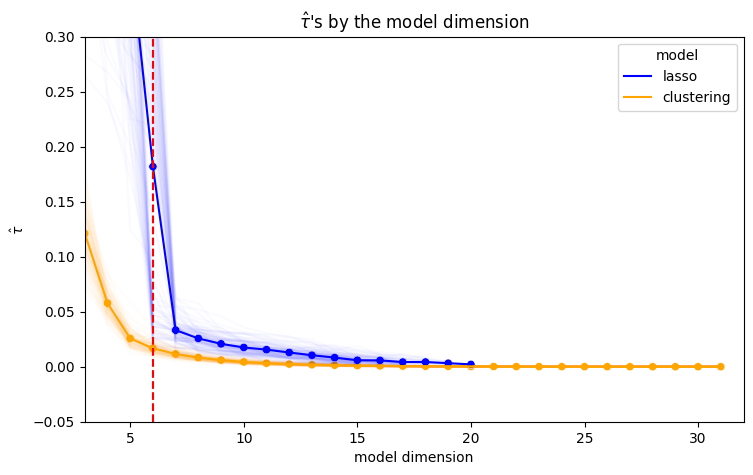

In [163]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
x_var = 'model dimension'
y_var = 'tau estimates'
for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var,  color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var,  hue = 'model', ax = ax,  palette=['blue', 'orange'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var,  hue = 'model', ax = ax, legend = False,  palette=['blue', 'orange'])

ax.vlines(x = 6, ymin =-.05, ymax = 1, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylim(-0.05, 0.3)
ax.set_ylabel(r'$\hat{\tau}$')
ax.set_title(r"$\hat{\tau}$'s by the model dimension")
fig.savefig('tau_estimate_lasso_cluster_dim_6.png')

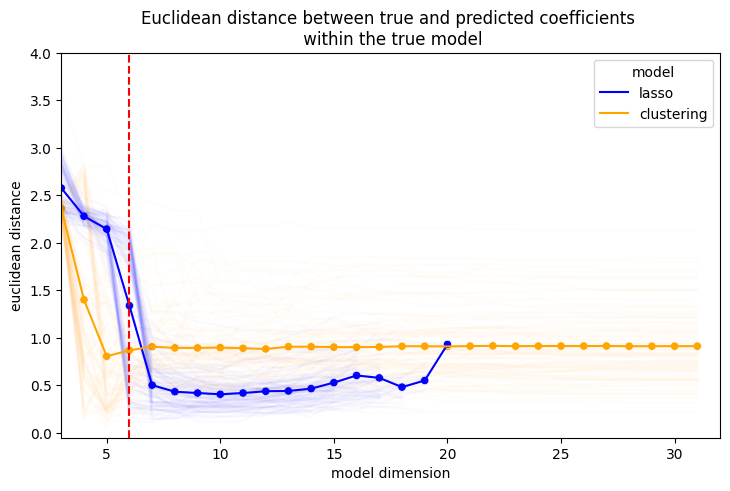

In [164]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
y_var = 'd(true, prediction) where true coefficients are 1'
for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax,  palette=['blue', 'orange'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax, legend = False,  palette=['blue', 'orange'])

ax.vlines(x = 6, ymin =-.05, ymax =5, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylim(-0.05, 4)
ax.set_ylabel('euclidean distance')
ax.set_title('Euclidean distance between true and predicted coefficients \n within the true model')
fig.savefig('true_euclidean_lasso_cluster_dim_6.png')


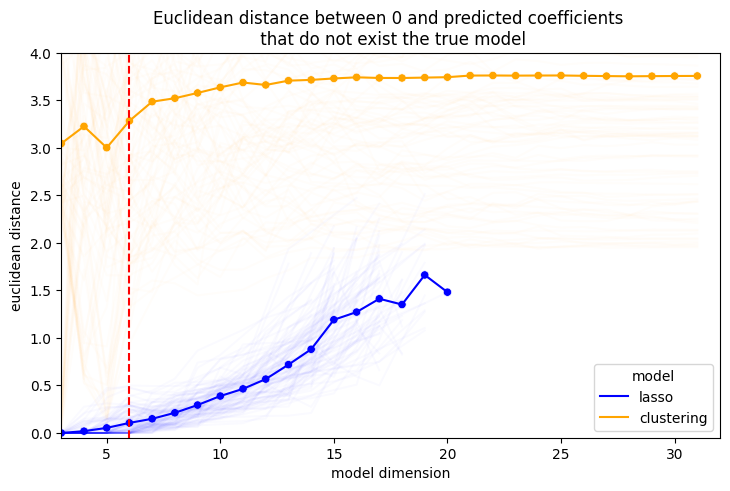

In [166]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
y_var = 'd(true, prediction) where true coefficients are 0'

for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax,  palette=['blue', 'orange'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax, legend = False,  palette=['blue', 'orange'])

ax.vlines(x = 6, ymin =-.05, ymax =5, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylim(-0.05, 4)
ax.set_ylabel('euclidean distance')
ax.set_title('Euclidean distance between 0 and predicted coefficients \n that do not exist the true model')
fig.savefig('false_euclidean_lasso_cluster_dim_6.png')


In [150]:
lasso_cluster_distance_results = [lasso_cluster_distance(df) for df in results]
# final_results_distance = pd.concat(results)

In [151]:
for i, result in enumerate(lasso_cluster_distance_results):
    result['iteration'] = i

In [152]:
final_results_distance = pd.concat(lasso_cluster_distance_results)

In [153]:
final_results_distance_mean = final_results_distance.groupby('model dimension').agg({'distance': np.mean})

In [154]:
x_var = 'model dimension'
y_var = 'distance'

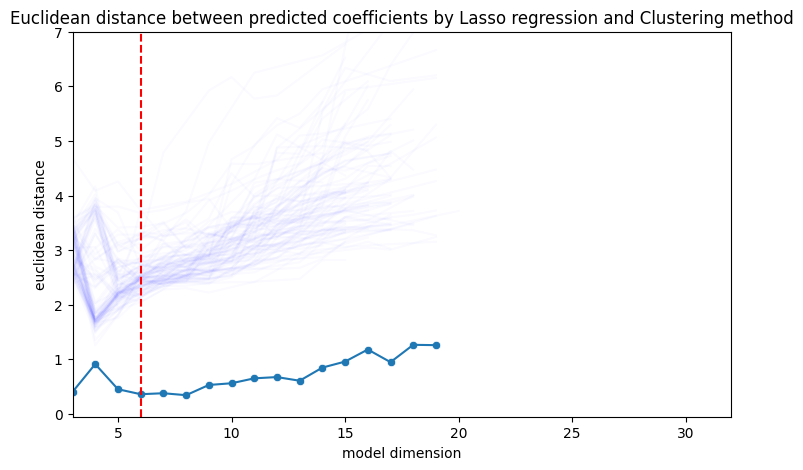

In [158]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
for i in range(100):
    sns.lineplot(data = final_results_distance.loc[final_results_distance.iteration.eq(i)], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_results_distance_mean, x = x_var, y = y_var,ax = ax)
sns.scatterplot(data = final_results_distance_mean, x = x_var, y = y_var, ax = ax, legend = False)

ax.vlines(x = 6, ymin =-.05, ymax =7, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylim(-0.05, 7)
ax.set_ylabel('euclidean distance')
ax.set_title('Euclidean distance between predicted coefficients by Lasso regression and Clustering method')
fig.savefig('between_models_euclidean_lasso_cluster_dim_6.png')


In [156]:
final_results_distance_mean = final_results_distance.groupby('model dimension').agg({'distance': np.std})

In [157]:
final_results_distance_mean

,distance
model dimension,
2,0.645631
3,0.403745
4,0.913483
5,0.453821
6,0.362166
7,0.380090
8,0.344235
9,0.531201
10,0.562836


In [ ]:
final_result = pd.concat(results)
final_result_means = final_result.groupby(['model dimension','model']).agg({'tau estimates': np.mean,
                                                          'd(true, prediction) where true coefficients are 1': np.mean, 
                                                          'd(true, prediction) where true coefficients are 0':np.mean}).reset_index()

#### When $p*$ is 10

hiarchical : $y = 1 + x_1 + x_2 + x_3 + x_4 +  x_1 x_2 + x_1 x_3+ x_1 x_4 + x_3 x_4 + x_1 x_2 x_3 $

In [33]:
true_beta = ['beta0','beta1','beta2','beta3','beta4','beta1*beta2', 'beta1*beta3', 'beta1*beta4', 'beta3*beta4', 'beta1*beta2*beta3']

In [34]:
def gen_y(seq, error_var = 2):
    y = 1 + seq.x1 + seq.x2 + seq.x3 + seq.x4 + seq.x1 * seq.x2 + seq.x1 * seq.x3 + seq.x3 * seq.x4 + seq.x1 * seq.x2 *seq.x3 
    y += np.random.normal(scale = sqrt(error_var))
    return y

In [35]:
def gen_cluster_output(X, y, true_beta):
    y.name = 'y'
    df = pd.concat([X, y], axis = 1)
    clustering = anova_clustering(df.iloc[:, :-1], df.y)
    true_beta_coef = np.array([True if x in true_beta else False for x in clustering.beta_names])

    num_clusters = list(range(2, 2**5))
    tau_estimates = []
    true_distance = []
    false_distance = []
    for k in num_clusters:
        tau_est = tau(df.shape[0], 2**5, k, clustering.estimator.score, clustering.metric_after_clustering(num_clusters = k))
        tau_estimates.append(tau_est.tau_est)
        true_pred = clustering.get_projected_beta_hat(k)[true_beta_coef]
        false_pred = clustering.get_projected_beta_hat(k)[~true_beta_coef]

        true_distance.append(euclidean([1 for _ in range(10)], true_pred))
        false_distance.append(euclidean([0 for _ in range(22)], false_pred))
        
    tau_output = pd.DataFrame(zip(num_clusters, tau_estimates, true_distance, false_distance), columns = ['model dimension','tau estimates', 'd(true, prediction) where true coefficients are 1', 'd(true, prediction) where true coefficients are 0'])
    tau_output['model'] = 'clustering'

    return tau_output, true_beta_coef


In [36]:
def gen_lasso_output(X, y, true_beta_coef):
    d_f = 32
    alpha = 0
    reg = LinearRegression()
    X_full = gen_full_X(X)
    reg.fit(X_full, y)
    org_score = reg.score(X_full, y)
    degrees_of_freedom = []
    tau_estimates = []
    alphas = []
    true_distance = []
    false_distance = []

    while d_f > 2:
        alpha += 0.001
        lasso = Lasso(alpha = alpha, fit_intercept = True)
        lasso.fit(X_full, y)
        lasso_coef = np.array([lasso.intercept_] + lasso.coef_.tolist())
        d_f = np.where(lasso_coef > 0.00001, 1, 0).sum()
        tau_est = tau(X_full.shape[0], 2**5, d_f, org_score, lasso.score(X_full, y))
        if (d_f not in degrees_of_freedom) & (d_f < 32):
            degrees_of_freedom.append(d_f)
            tau_estimates.append(tau_est)
            alphas.append(round(alpha, 3))
            false_pred = lasso_coef[~true_beta_coef]
            true_pred = lasso_coef[true_beta_coef]
            false_distance.append(euclidean([0 for _ in range(22)], false_pred))
            true_distance.append(euclidean([1 for _ in range(10)], true_pred))
    tau_output_lasso = pd.DataFrame(zip(degrees_of_freedom, [x.tau_est for x in tau_estimates], true_distance, false_distance), columns = ['model dimension','tau estimates', 'd(true, prediction) where true coefficients are 1', 'd(true, prediction) where true coefficients are 0'])
    tau_output_lasso['model'] = 'lasso'

    return tau_output_lasso

In [37]:
def simulation(true_beta, sample_size = 1000):
    X = gen_X(5, sample_size)
    y = X.apply(gen_y, axis = 1)
    y.name = 'y'
    cluster_output, true_beta_coef  = gen_cluster_output(X, y, true_beta)
    lasso_output = gen_lasso_output(X, y, true_beta_coef)
    output = pd.concat([cluster_output, lasso_output]).reset_index(drop = True)
    return output

In [38]:
from joblib import Parallel, delayed
from tqdm import tqdm

results = Parallel(n_jobs=-1)(delayed(simulation)(true_beta) for _ in tqdm(range(100)))


100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


In [39]:
for i, result in enumerate(results):
    result['iteration'] = i

In [40]:
final_result = pd.concat(results)

In [41]:
final_result_means = final_result.groupby(['model dimension','model']).agg({'tau estimates': np.mean,
                                                          'd(true, prediction) where true coefficients are 1': np.mean, 
                                                          'd(true, prediction) where true coefficients are 0':np.mean}).reset_index()

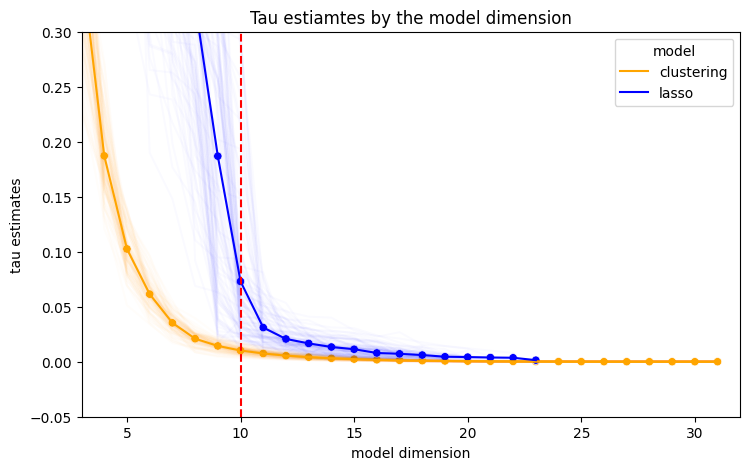

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
y_var = 'tau estimates'
for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax,  palette=['orange', 'blue'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax, legend = False,  palette=['orange', 'blue'])

ax.vlines(x = 10, ymin =-.05, ymax = 1, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylim(-0.05, 0.3)
ax.set_title('Tau estiamtes by the model dimension')
fig.savefig('tau_estimate_lasso_cluster_dim_10.png')

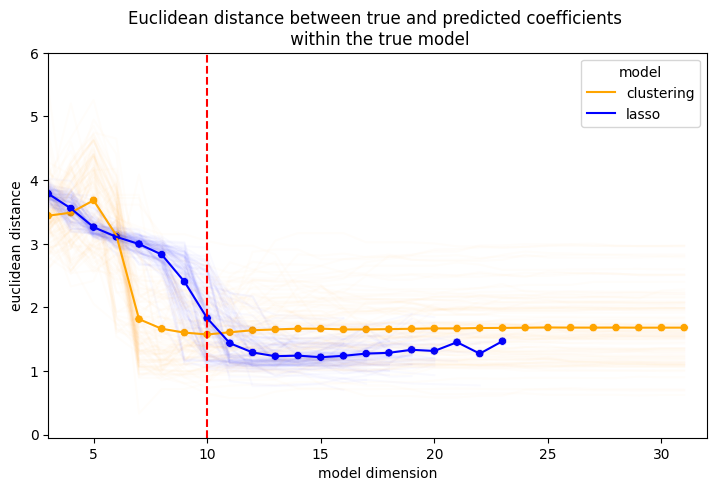

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
y_var = 'd(true, prediction) where true coefficients are 1'
for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax,  palette=['orange', 'blue'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax, legend = False,  palette=['orange', 'blue'])

ax.vlines(x = 10, ymin =-.05, ymax =6, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylabel('euclidean distance')
ax.set_ylim(-0.05, 6)
ax.set_title('Euclidean distance between true and predicted coefficients \n within the true model')
fig.savefig('true_euclidean_lasso_cluster_dim_10.png')

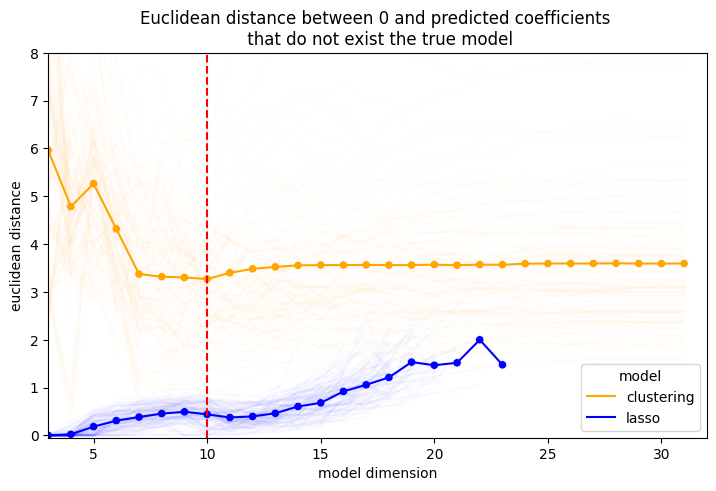

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (8.5, 5))
y_var = 'd(true, prediction) where true coefficients are 0'
for i in range(100):
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("clustering")], x = x_var, y = y_var, color = 'orange', alpha = .02, ax = ax)
    sns.lineplot(data = final_result.loc[final_result.iteration.eq(i)&final_result.model.eq("lasso")], x = x_var, y = y_var, color = 'blue', alpha = .02, ax = ax)
sns.lineplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax,  palette=['orange', 'blue'])
sns.scatterplot(data = final_result_means, x = x_var, y = y_var, hue = 'model', ax = ax, legend = False,  palette=['orange', 'blue'])

ax.vlines(x = 10, ymin =-.05, ymax =8, color = 'red', linestyles='--')
ax.set_xlim(3, 32)
ax.set_ylabel('euclidean distance')
ax.set_ylim(-0.05, 8)
ax.set_title('Euclidean distance between 0 and predicted coefficients \n that do not exist the true model')
fig.savefig('false_euclidean_lasso_cluster_dim_10.png')
